
# Detecting Subsidy Candidates in Colombia: A Predictive Approach Using the GEIH



## 2.1 Database Context
The GEIH (Gran Encuesta Integrada de Hogares) is a national survey conducted in Colombia that collects detailed information on households’ socioeconomic conditions and the labor market. It is implemented using a probabilistic, stratified sampling design—that is, the population is divided into groups (strata) sharing similar characteristics, and a random sample is drawn within each stratum to improve estimate precision and reduce sampling error.

This statistical approach yields representative estimates at the national, departmental, and municipal levels. The survey includes key variables such as income and expenditure, working hours, educational attainment, housing characteristics, labor status (formal or informal employment), pension access, and demographic data (e.g., number of children).

According to DANE, the purpose of this survey is:  
> “To provide statistical information related to the labor market, income and monetary poverty, as well as the socio-demographic characteristics of the population residing in Colombia.”

Finally, **the study universe** comprises the non-institutionalized civilian population living throughout the national territory (excluding certain areas such as Providencia and San Andrés). In this dataset, each observation (row) corresponds to a household, its dwelling, and the individuals within it.

## 2.2 Problem Description
This project focuses on analyzing the GEIH database to evaluate whether the subsidies implemented in Colombia have effectively reduced socioeconomic inequality and been properly targeted to the most vulnerable households and individuals. To achieve this, we will examine key indicators—such as household income, educational attainment, and labor market status—to assess the accuracy of resource allocation. Based on these insights, a predictive classification model will be developed to optimize subsidy distribution, ensuring state resources reach the neediest populations and contribute to a fairer, more focused public policy.

## 2.3 Guiding Question
**How do subsidies impact the reduction of inequality in Colombia, and which combinations of GEIH variables reveal whether those subsidies are correctly targeted at the most vulnerable households and individuals?**


# 3. Objectives
***

## 3.1 General Objective
Develop a predictive model using GEIH data to effectively identify vulnerable households and individuals in Colombia, optimizing subsidy allocation and improving public policy decision-making.

## 3.2 Specific Objectives

- Assess the effectiveness of current subsidy allocation by comparing the socioeconomic characteristics of beneficiaries against the general population, determining whether resources are reaching the most needy households and individuals.
- Design and validate a classification model that leverages these indicators to predict subsidy eligibility, evaluating its performance with appropriate statistical metrics.
- Identify the key variables that drive the predictive model’s learning process, quantifying their impact on classifying beneficiary households and individuals to further refine subsidy targeting.


# 4. Development

## 4.1. Libraries to be used

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
from functools import reduce
import random
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder , MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split , cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier

## 4.2. Create the DataSet

### For all the DataBases we are going to select only the variables that we need for this analysis

In [ ]:
generales = pd.read_csv("C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\8 semestre\\Data mining\\CSV\\Características generales, seguridad social en salud y educación.CSV" , sep=";" ,encoding="latin-1")
laborales =pd.read_csv("C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\8 semestre\\Data mining\\CSV\\Ocupados.CSV" , sep=";" ,encoding="latin-1")
hogar = pd.read_csv("C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\8 semestre\\Data mining\\CSV\\Datos del hogar y la vivienda.CSV" , sep=";" ,encoding="latin-1")
subsidios = pd.read_csv("C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\8 semestre\\Data mining\\CSV\\Otros ingresos e impuestos.CSV" , sep=";" ,encoding="latin-1")
fuerza_trabajo = pd.read_csv("C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\8 semestre\\Data mining\\CSV\\Fuerza de trabajo.CSV" , sep=";" ,encoding="latin-1")
desempleados = pd.read_csv("C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\8 semestre\\Data mining\\CSV\\No ocupados.CSV" , sep=";" ,encoding="latin-1")

### General characteristics DataBase

In [3]:
generales = generales[['DIRECTORIO' , 'DPTO' ,'P6040' ,'P6080' ,'P6100' ,'P3039' ,'P3042']]

rename_mapping = {
    'DIRECTORIO':'Directorio',
    'DPTO':'Departamento',
    "P6040": "Edad",                        
    "P6080": "Etnia",                        
    "P6100": "Sistema de Salud",
    "P3039": "Genero",
    'P3042': 'Educacion Maxima'                     
}
generales.rename(columns=rename_mapping, inplace=True)
generales

,Directorio,Departamento,Edad,Etnia,Sistema de Salud,Genero,Educacion Maxima
0,7770597,63,62,6,3.0,1.0,3.0
1,7770597,63,61,6,3.0,2.0,3.0
2,7770598,63,27,6,3.0,2.0,9.0
3,7770598,63,2,6,3.0,NaN,NaN
4,7770599,63,55,6,3.0,1.0,3.0
...,...,...,...,...,...,...,...
70183,7798965,23,10,1,3.0,NaN,4.0
70184,7798965,23,8,1,3.0,NaN,3.0
70185,7798967,23,54,1,3.0,2.0,5.0
70186,7798967,23,20,1,2.0,1.0,10.0


### Markel Labor Databases

In [4]:
laborales = laborales[['DIRECTORIO' , 'DPTO' , 'P6460' ,'P6440' ,'P6426' ,'INGLABO' ,'P6620S1','P6510S1',
                       'P6585S1A1' ,'P6585S2A1','P6585S3A1','P6585S4A1', 'P6545S1','P6580S1',
                       'P6630S1A1','P6630S2A1','P6630S3A1','P6630S4A1','P6800' ,'P6920' ,'P7140S7' ,'P514' , 'P7140S6', 'P7100']]
rename_mapping = {
    'DIRECTORIO':'Directorio',
    'DPTO':'Departamento',
    "P6440": "Tiene contrato",                        
    "P6460": "Tipo de contrato",                        
    "P6426": "Meses en la empresa",
    "INGLABO": "INGRESOS BASE",
    'P6620S1': 'Ingresos especie',
    'P6510S1': 'Ingresos extra',
    "P6585S1A1": "Auxilio alimentación",
    "P6585S2A1": "Auxilio Transporte",
    "P6585S3A1": "Subsidio Familiar",
    "P6585S4A1": "Subsidio Educativo",
    "P6545S1": "Primas",
    "P6580S1": "Bonificaciones",
    "P6630S1A1": "Prima servicios",
    "P6630S2A1": "Prima navidad",
    "P6630S3A1": "Prima vacaciones",
    "P6630S4A1": "Primas anuales",
    "P6800": "Horas de trabajo semanales",
    "P6920": "Fondo de pensiones",                     
    "P7140S7": "Exigencia física o mental",            
    "P514": "Trabajo estable",
    'P7140S6': "Desagrado por el trabajo",
    'P7100':'Horas Adicionales'                       
}

laborales.rename(columns=rename_mapping, inplace=True)

variables_ingresos = [
    'Ingresos especie',
    'Ingresos extra',
    'Auxilio alimentación',
    'Auxilio Transporte',
    'Subsidio Familiar',
    'Subsidio Educativo',
    'Primas',
    'Bonificaciones',
    'Prima servicios',
    'Prima navidad',
    'Prima vacaciones',
    'Primas anuales'
]

laborales[variables_ingresos] = laborales[variables_ingresos].fillna(0)
laborales['Ingresos finales'] = laborales['INGRESOS BASE'] + laborales[variables_ingresos].sum(axis=1)
laborales = laborales[['Directorio', 'Tipo de contrato' , 'Tiene contrato' , 'Meses en la empresa' ,'Fondo de pensiones' ,
           'Exigencia física o mental' ,'Trabajo estable' ,'Desagrado por el trabajo' ,'Horas Adicionales' ,'Ingresos finales' ,'Subsidio Familiar' ,'Subsidio Educativo']]
laborales

,Directorio,Tipo de contrato,Tiene contrato,Meses en la empresa,Fondo de pensiones,Exigencia física o mental,Trabajo estable,Desagrado por el trabajo,Horas Adicionales,Ingresos finales,Subsidio Familiar,Subsidio Educativo
0,7770597,NaN,2,480,2,NaN,1,NaN,NaN,960000.0,0.0,0.0
1,7770597,NaN,2,120,2,NaN,1,NaN,NaN,NaN,0.0,0.0
2,7770598,NaN,1,2,2,NaN,2,NaN,NaN,240000.0,0.0,0.0
3,7770599,NaN,2,5,2,NaN,1,NaN,NaN,1000000.0,0.0,0.0
4,7770600,NaN,1,192,2,NaN,1,NaN,NaN,1000000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
30137,7798962,NaN,2,24,2,2.0,2,2.0,30.0,30000.0,0.0,0.0
30138,7798965,NaN,2,36,2,NaN,1,NaN,NaN,430000.0,0.0,0.0
30139,7798965,NaN,1,3,2,2.0,1,2.0,NaN,150000.0,0.0,0.0
30140,7798967,NaN,2,120,2,NaN,2,NaN,20.0,200000.0,0.0,0.0


### Labor Force DataBase

In [5]:
fuerza_trabajo = fuerza_trabajo[['P6240', 'DIRECTORIO']]
fuerza_trabajo['Empleado'] = fuerza_trabajo['P6240'].isin([1, 3]).astype(int)

rename_mapping = {
    'DIRECTORIO':'Directorio',
    'P6240':'Actividad realizada',
    "Empleado": "Empleado" }

fuerza_trabajo.rename(columns=rename_mapping, inplace=True)
fuerza_trabajo

,Actividad realizada,Directorio,Empleado
0,1,7770597,1
1,4,7770597,0
2,4,7770598,0
3,1,7770599,1
4,5,7770599,0
...,...,...,...
55768,1,7798965,1
55769,1,7798965,1
55770,4,7798967,0
55771,3,7798967,1


### Unemployment DataBase

In [6]:
desempleados = desempleados[['P7250' , 'P7440S1' , 'P9460' , 'P7422' ,'DIRECTORIO']]

rename_mapping = {
    'P7250':'Semanas Buscando Trabajo',
    'P7440S1':'Meses sin trabajo',
    "P7422": "Ingresos Mes Pasado" ,
    'P9460':'Subsidio Desempleo',
    'DIRECTORIO': 'Directorio'
    }

desempleados.rename(columns=rename_mapping, inplace=True)
desempleados

,Semanas Buscando Trabajo,Meses sin trabajo,Subsidio Desempleo,Ingresos Mes Pasado,Directorio
0,NaN,240.0,2.0,2,7770599
1,NaN,12.0,2.0,2,7770603
2,NaN,NaN,NaN,2,7770604
3,NaN,NaN,NaN,2,7770605
4,16.0,4.0,2.0,2,7770606
...,...,...,...,...,...
25626,NaN,12.0,2.0,2,7798963
25627,NaN,NaN,NaN,2,7798963
25628,NaN,NaN,NaN,2,7798963
25629,NaN,340.0,2.0,2,7798965


### House Characteristics DataBase

In [7]:
hogar = hogar[['P4030S1' ,'P4020' ,'P4030S3' ,'P4030S5' ,'P6008' ,'DIRECTORIO' , 'P6008' ,'P5090','P5100' , 'P5140' ,'P4030S2' ,'P4030S4']]

rename_mapping = {
    'DIRECTORIO':'Directorio',
    'P6008':'N_Personas',
    "P5090": "Tipo de Vivienda",
    'P5100': 'Cuota Amotrtizacion',
    'P5140': 'Arriendo', 
    'P4030S1': 'Energia Electrica', 
    'P4020': 'Material Casa', 
    'P4030S3':'Alcantarillado',
    'P4030S5':'Acueducto',
    'P4030S2':'Gas Natural', 
    'P4030S4': 'Recoleccion Basura'}

hogar.rename(columns=rename_mapping, inplace=True)
hogar

,Energia Electrica,Material Casa,Alcantarillado,Acueducto,N_Personas,Directorio,N_Personas,Tipo de Vivienda,Cuota Amotrtizacion,Arriendo,Gas Natural,Recoleccion Basura
0,1,4,1,1,2,7770597,2,3,NaN,300000.0,1,1
1,1,2,1,1,2,7770598,2,4,NaN,NaN,1,1
2,1,4,1,1,2,7770599,2,1,NaN,NaN,1,1
3,1,2,1,1,1,7770600,1,3,NaN,220000.0,2,1
4,1,2,1,1,1,7770601,1,3,NaN,150000.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
24564,1,2,2,1,5,7798962,5,4,NaN,NaN,2,2
24565,1,4,2,1,4,7798963,4,4,NaN,NaN,2,2
24566,1,4,2,1,5,7798965,5,1,NaN,NaN,2,2
24567,1,4,2,1,2,7798967,2,4,NaN,NaN,2,2


### Subsidy DataBase

In [8]:
subsidios = subsidios[['P7510S3' ,'DIRECTORIO' , 'P7510S2A1' , 'P7510S3A1' , 'P750S1A1' , 'P750S2A1' , 'P1661S1A1' , 'P1661S2A1' , 'P1661S3A1']]

rename_mapping = {
    'DIRECTORIO': 'Directorio',
    'P7510S3': 'Subsidios',
    'P7510S2A1': 'Valor 1',
    'P7510S3A1': 'Valor 2',
    'P750S1A1': 'Valor 3',
    'P750S2A1': 'Valor 4',
    'P1661S1A1': 'Valor 5',
    'P1661S2A1': 'Valor 6',
    'P1661S3A1': 'Valor 7'
}

subsidios.rename(columns=rename_mapping, inplace=True)
subsidios.iloc[: ,2:] = subsidios.iloc[: ,2:].fillna(0)
subsidios.iloc[: ,2:] = subsidios.iloc[: ,2:].fillna(0)

subsidios['Valor Subsidio'] = subsidios.iloc[:, 2:].apply(lambda row: reduce(lambda x, y: x + y, row), axis=1)
cols_to_drop = subsidios.columns[2:9]
subsidios = subsidios.drop(cols_to_drop, axis=1)
subsidios

,Subsidios,Directorio,Valor Subsidio
0,NaN,7770597,0.0
1,1.0,7770597,2400000.0
2,2.0,7770598,0.0
3,NaN,7770599,0.0
4,NaN,7770599,0.0
...,...,...,...
55768,NaN,7798965,0.0
55769,2.0,7798965,0.0
55770,2.0,7798967,0.0
55771,2.0,7798967,0.0


### Final DataBase

In [9]:
dataframes = [generales, laborales, hogar, fuerza_trabajo, desempleados, subsidios]
df_final = reduce(lambda left, right: pd.merge(left, right, on='Directorio', how='inner'), dataframes)
df_final

,Directorio,Departamento,Edad,Etnia,Sistema de Salud,Genero,Educacion Maxima,Tipo de contrato,Tiene contrato,Meses en la empresa,...,Gas Natural,Recoleccion Basura,Actividad realizada,Empleado,Semanas Buscando Trabajo,Meses sin trabajo,Subsidio Desempleo,Ingresos Mes Pasado,Subsidios,Valor Subsidio
0,7770599,63,55,6,3.0,1.0,3.0,NaN,2,5,...,1,1,1,1,NaN,240.0,2.0,2,NaN,0.0
1,7770599,63,55,6,3.0,1.0,3.0,NaN,2,5,...,1,1,1,1,NaN,240.0,2.0,2,NaN,0.0
2,7770599,63,55,6,3.0,1.0,3.0,NaN,2,5,...,1,1,5,0,NaN,240.0,2.0,2,NaN,0.0
3,7770599,63,55,6,3.0,1.0,3.0,NaN,2,5,...,1,1,5,0,NaN,240.0,2.0,2,NaN,0.0
4,7770599,63,77,6,1.0,2.0,3.0,NaN,2,5,...,1,1,1,1,NaN,240.0,2.0,2,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225005,7798967,23,54,1,3.0,2.0,5.0,NaN,2,120,...,2,2,3,1,NaN,NaN,NaN,2,2.0,0.0
3225006,7798967,23,20,1,2.0,1.0,10.0,NaN,2,120,...,2,2,4,0,NaN,NaN,NaN,2,2.0,0.0
3225007,7798967,23,20,1,2.0,1.0,10.0,NaN,2,120,...,2,2,4,0,NaN,NaN,NaN,2,2.0,0.0
3225008,7798967,23,20,1,2.0,1.0,10.0,NaN,2,120,...,2,2,3,1,NaN,NaN,NaN,2,2.0,0.0


### Now we need to filter the final database, combining the subsidies into a single variable...

In [10]:
def combinar_valores(row):
    a = row['Arriendo']
    b = row['Cuota Amotrtizacion']
    if pd.isna(a) and pd.isna(b):
        return np.nan
    elif pd.isna(a):
        return b
    elif pd.isna(b):
        return a
    else:
        return (a + b) / 2

cols = ["Subsidio Familiar", "Subsidio Educativo", "Subsidio Desempleo", "Subsidios"]

df_final['Subsidio'] = np.where(
    df_final[cols].isna().all(axis=1),
    np.nan,
    np.where(
        (df_final["Subsidio Desempleo"] == 1) |
        (df_final["Subsidios"] == 1),
        1,
        0
    )
)

df_final['Sistema de Salud'] = df_final['Sistema de Salud'].fillna(0)
df_final = df_final.drop(columns=['Genero' ,'Subsidio Educativo', "Subsidio Desempleo" ,"Subsidio Familiar" ,'Subsidios' ,'Semanas Buscando Trabajo' ])
df_final.loc[df_final['Tipo de contrato'].isna() & (df_final['Tiene contrato'] == 2), 'Tipo de contrato'] = 0
df_final['Horas Adicionales'] = df_final['Horas Adicionales'].fillna(0)
df_final['Meses sin trabajo'] = df_final['Meses sin trabajo'].fillna(0)
df_final

,Directorio,Departamento,Edad,Etnia,Sistema de Salud,Educacion Maxima,Tipo de contrato,Tiene contrato,Meses en la empresa,Fondo de pensiones,...,Cuota Amotrtizacion,Arriendo,Gas Natural,Recoleccion Basura,Actividad realizada,Empleado,Meses sin trabajo,Ingresos Mes Pasado,Valor Subsidio,Subsidio
0,7770599,63,55,6,3.0,3.0,0.0,2,5,2,...,NaN,NaN,1,1,1,1,240.0,2,0.0,0.0
1,7770599,63,55,6,3.0,3.0,0.0,2,5,2,...,NaN,NaN,1,1,1,1,240.0,2,0.0,0.0
2,7770599,63,55,6,3.0,3.0,0.0,2,5,2,...,NaN,NaN,1,1,5,0,240.0,2,0.0,0.0
3,7770599,63,55,6,3.0,3.0,0.0,2,5,2,...,NaN,NaN,1,1,5,0,240.0,2,0.0,0.0
4,7770599,63,77,6,1.0,3.0,0.0,2,5,2,...,NaN,NaN,1,1,1,1,240.0,2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225005,7798967,23,54,1,3.0,5.0,0.0,2,120,2,...,NaN,NaN,2,2,3,1,0.0,2,0.0,0.0
3225006,7798967,23,20,1,2.0,10.0,0.0,2,120,2,...,NaN,NaN,2,2,4,0,0.0,2,0.0,0.0
3225007,7798967,23,20,1,2.0,10.0,0.0,2,120,2,...,NaN,NaN,2,2,4,0,0.0,2,0.0,0.0
3225008,7798967,23,20,1,2.0,10.0,0.0,2,120,2,...,NaN,NaN,2,2,3,1,0.0,2,0.0,0.0


### As can see, we have 3 million observations and 32 variables, lets start with a EDA to understand how subsidies are distributed in the country

## 4.3. Analysis of the variables of interest.

In [11]:
intervalos = [0, 420000, 1680000.0 ,  8400000.0, float('inf')]
nombres = ['Pobreza Monetaria' ,'Clase Baja' ,'Clase media', 'Clase alta']
df_final['CLASE_SOCIAL'] = pd.cut(df_final['Ingresos finales'], bins=intervalos, labels=nombres, right=False)
df_final['CLASE_SOCIAL'].value_counts()

df_conS = df_final[df_final['Subsidio'] == 1]
df_sinS = df_final[df_final['Subsidio'] == 0]

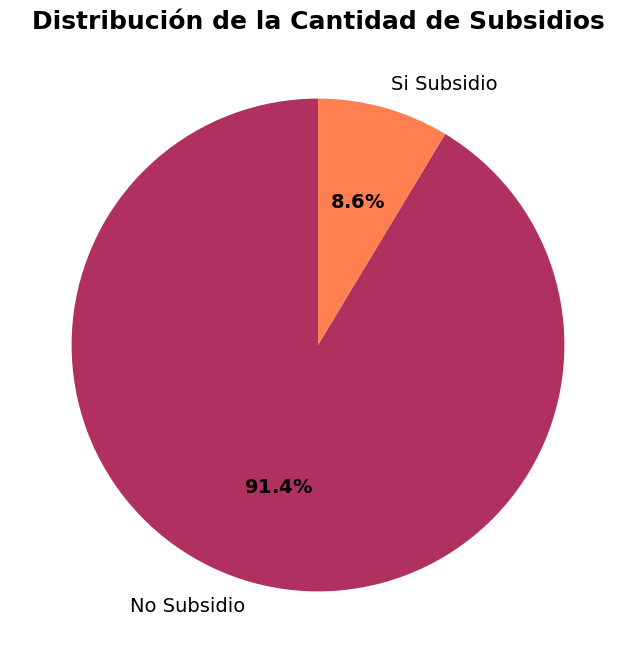

In [12]:
subsidio_counts = df_final['Subsidio'].value_counts()
labels = ['No Subsidio' if x == 0 else 'Si Subsidio' for x in subsidio_counts.index]

def make_autopct(values):
    def my_autopct(pct):
        return f"$\\bf{{{pct:.1f}\\%}}$"
    return my_autopct

plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    subsidio_counts,
    labels=labels, 
    autopct=make_autopct(subsidio_counts),
    startangle=90,
    colors=[ '#B03060','#FF7F50'],
    textprops={'fontsize': 14}         
)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(14)

plt.title("Distribución de la Cantidad de Subsidios", fontsize=18, fontweight='bold')
plt.show()

#### Distribution of Subsidies

The first step is to analyze the share of subsidies in the sample. From this chart, we can see that only **8.6%** of individuals receive any form of government subsidy, which corresponds to just **278,000** people. This is a very small proportion—especially in light of the considerable inequality in the country. We are therefore starting from an unfavorable baseline: people need state assistance, but the government is reaching only a limited number.

With this context in mind, the next question is whether the few subsidies granted are well targeted—or if they could be reallocated among households in a way that would have a stronger impact on reducing Colombia’s high inequality.

## 4.3.1 Monetary Poverty

In economics, we distinguish between **monetary poverty**—which measures households’ cash income or consumption against a fixed poverty line—and **multidimensional poverty**, which captures deprivations across health, education, living standards, and other non‐monetary dimensions. Monetary poverty is straightforward to quantify and track over time, making it ideal for assessing the direct impact of cash transfers and income‐based subsidies. Multidimensional poverty, on the other hand, provides a richer picture of household well-being by highlighting gaps in access to education, healthcare, housing quality, and basic services, helping policymakers design more holistic intervention packages. In this analysis, we will evaluate subsidy targeting through both lenses to understand not only whether cash support reaches those below the income threshold but also whether it effectively alleviates broader deprivations that perpetuate long‐term vulnerability.  


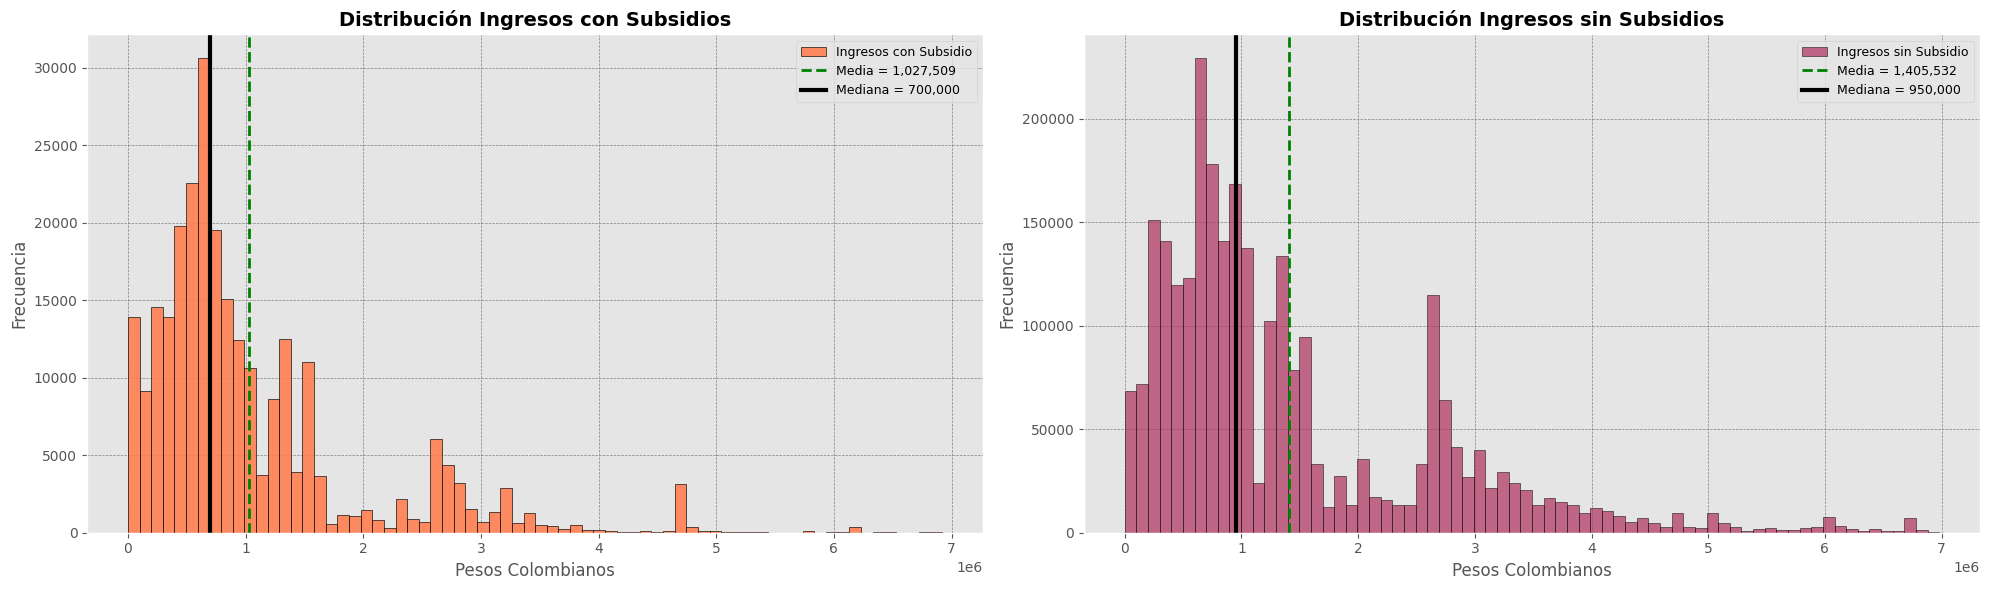

In [13]:
media_variable1 = df_conS[df_conS['Ingresos finales'] < 7000000]['Ingresos finales'].mean()
mediana_variable1 = df_conS[df_conS['Ingresos finales'] < 7000000]['Ingresos finales'].median()
media_variable2 = df_sinS[df_sinS['Ingresos finales'] < 7000000]['Ingresos finales'].mean()
mediana_variable2 = df_sinS[df_sinS['Ingresos finales'] < 7000000]['Ingresos finales'].median()

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

n1, bins1, patches1 = ax1.hist(
    df_conS[df_conS['Ingresos finales'] < 7000000]['Ingresos finales'], 
    bins=70, 
    alpha=0.9, 
    edgecolor='black', 
    label='Ingresos con Subsidio')
for patch in patches1:
    patch.set_facecolor('#FF7F50')

ax1.set_title('Distribución Ingresos con Subsidios', fontsize=14, weight='bold')
ax1.set_xlabel('Pesos Colombianos')
ax1.set_ylabel('Frecuencia')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax1.axvline(x=media_variable1, color='green', linestyle='dashed', linewidth=2, label=f'Media = {media_variable1:,.0f}')
ax1.axvline(x=mediana_variable1, color='black', linestyle='-', linewidth=3,  label=f'Mediana = {mediana_variable1:,.0f}')
ax1.legend(fontsize=9)

n2, bins2, patches2 = ax2.hist(
    df_sinS[df_sinS['Ingresos finales'] < 7000000]['Ingresos finales'], 
    bins=70, 
    alpha=0.7, 
    edgecolor='black', 
    label='Ingresos sin Subsidio')

for patch in patches2:
    patch.set_facecolor('#B03060')

ax2.set_title('Distribución Ingresos sin Subsidios', fontsize=14, weight='bold')
ax2.set_xlabel('Pesos Colombianos')
ax2.set_ylabel('Frecuencia')
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax2.axvline(x=media_variable2, color='green', linestyle='dashed', linewidth=2, label=f'Media = {media_variable2:,.0f}')
ax2.axvline(x=mediana_variable2, color='black', linestyle='-', linewidth=3,  label=f'Mediana = {mediana_variable2:,.0f}')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.show()



These histograms show how incomes are distributed for individuals **with** and **without** government subsidies. At first glance, both distributions are right-skewed (mean > median). However, the mean income of non-recipients is substantially higher—since subsidies are directed at lower-income households, while the non-recipient group includes higher earners that pull the average up.

A closer look reveals that subsidy recipients’ incomes are heavily concentrated below COP 700,000, highlighting their greater monetary vulnerability.

One important caveat is that we don’t know if the reported income figures include the subsidy itself. For a true assessment of the subsidy’s impact, we must compare the declared pre-subsidy income against the subsidy amount actually received.

C:\Users\alejo\AppData\Local\Temp\ipykernel_22476\1043375382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conS['diferencia'] = df_conS['Ingresos finales'] - df_conS['Valor Subsidio']


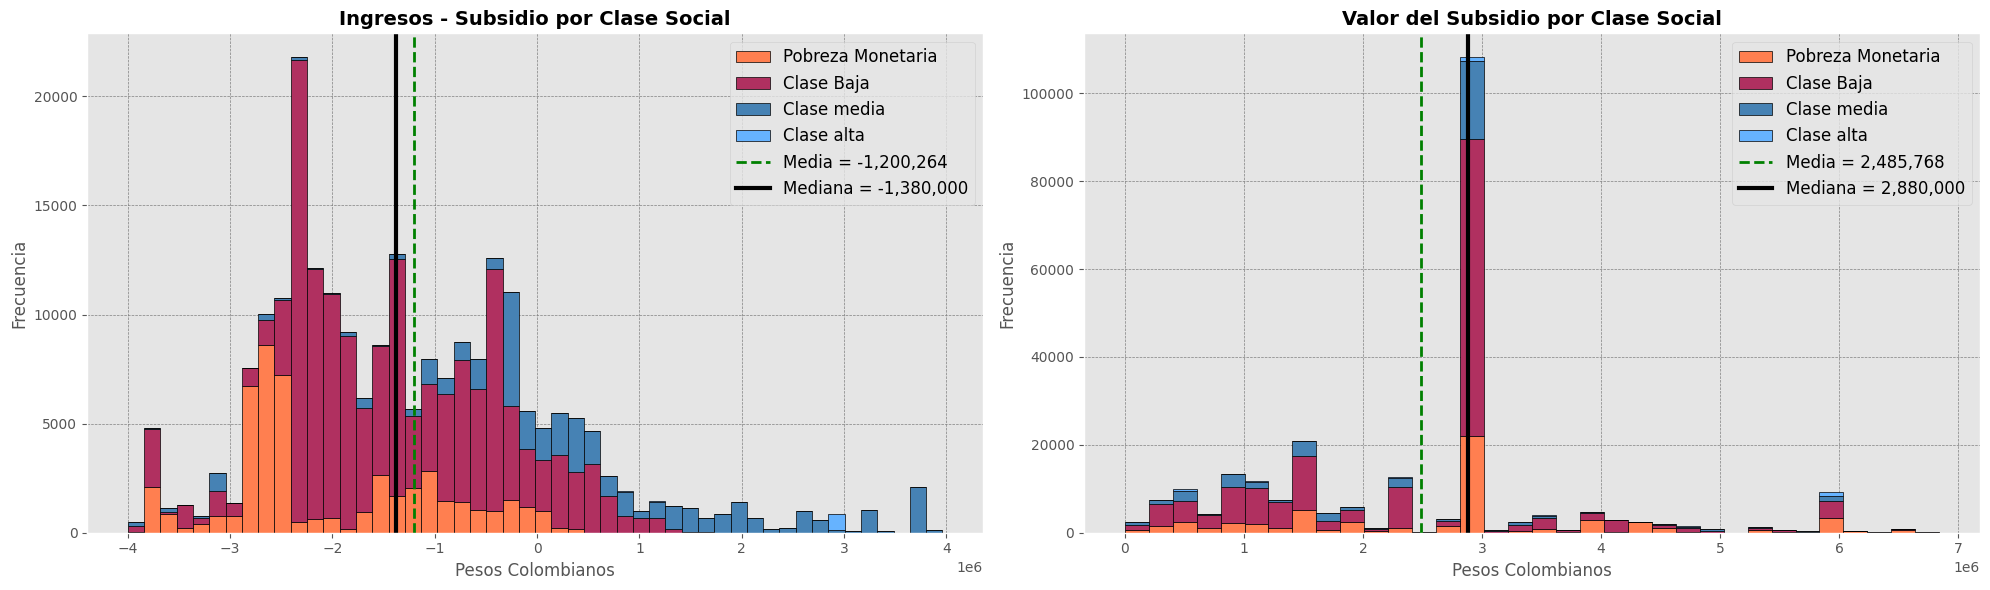

In [14]:
df_conS['diferencia'] = df_conS['Ingresos finales'] - df_conS['Valor Subsidio']
df_filtrado = df_conS[(df_conS['diferencia'] >= -4e6) & (df_conS['diferencia'] <= 4e6)]

pobreza_diff     = df_filtrado[df_filtrado['CLASE_SOCIAL'] == 'Pobreza Monetaria']['diferencia']
clase_baja_diff  = df_filtrado[df_filtrado['CLASE_SOCIAL'] == 'Clase Baja']['diferencia']
clase_media_diff = df_filtrado[df_filtrado['CLASE_SOCIAL'] == 'Clase media']['diferencia']
clase_alta_diff  = df_filtrado[df_filtrado['CLASE_SOCIAL'] == 'Clase alta']['diferencia']

media_variable1 = df_filtrado['diferencia'].mean()
mediana_variable1 = df_filtrado['diferencia'].median()
df_subsidio = df_conS[df_conS['Valor Subsidio'] < 7000000]


pobreza_val     = df_subsidio[df_subsidio['CLASE_SOCIAL'] == 'Pobreza Monetaria']['Valor Subsidio']
clase_baja_val  = df_subsidio[df_subsidio['CLASE_SOCIAL'] == 'Clase Baja']['Valor Subsidio']
clase_media_val = df_subsidio[df_subsidio['CLASE_SOCIAL'] == 'Clase media']['Valor Subsidio']
clase_alta_val  = df_subsidio[df_subsidio['CLASE_SOCIAL'] == 'Clase alta']['Valor Subsidio']

media_variable2 = df_subsidio['Valor Subsidio'].mean()
mediana_variable2 = df_subsidio['Valor Subsidio'].median()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist([pobreza_diff, clase_baja_diff, clase_media_diff, clase_alta_diff],
         bins=50,
         stacked=True,
         color=['#FF7F50', '#B03060', '#4682B4', '#66b3ff'],
         label=['Pobreza Monetaria', 'Clase Baja', 'Clase media', 'Clase alta'],
         edgecolor='black')
ax1.set_title('Ingresos - Subsidio por Clase Social', fontsize=14, fontweight='bold')
ax1.set_xlabel('Pesos Colombianos')
ax1.set_ylabel('Frecuencia')
ax1.axvline(x=media_variable1, color='green', linestyle='dashed', linewidth=2, label=f'Media = {media_variable1:,.0f}')
ax1.axvline(x=mediana_variable1, color='black', linestyle='-', linewidth=3, label=f'Mediana = {mediana_variable1:,.0f}')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax1.legend(fontsize=12)

ax2.hist([pobreza_val, clase_baja_val, clase_media_val, clase_alta_val],
         bins=34,
         stacked=True,
         color=['#FF7F50', '#B03060', '#4682B4', '#66b3ff'],
         label=['Pobreza Monetaria', 'Clase Baja', 'Clase media', 'Clase alta'],
         edgecolor='black')
ax2.set_title('Valor del Subsidio por Clase Social', fontsize=14, fontweight='bold')
ax2.axvline(x=media_variable2, color='green', linestyle='dashed', linewidth=2, label=f'Media = {media_variable2:,.0f}')
ax2.axvline(x=mediana_variable2, color='black', linestyle='-', linewidth=3, label=f'Mediana = {mediana_variable2:,.0f}')
ax2.set_xlabel('Pesos Colombianos')
ax2.set_ylabel('Frecuencia')
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()

The first panel plots **(Income – Subsidy)** by social class:

- **Negative values** indicate the subsidy exceeds the household’s declared monthly income.
- **Zero** implies that the subsidy equals (or constitutes) the entire reported income.
- **Positive values** mean the household’s own earnings surpass the subsidy amount.

A few key observations:

1. Very few positive entries—and those that exist are mostly in the middle‐ and upper‐class strata—suggest these households receive the subsidy as a pure top-up rather than as essential support.
2. The vast majority of zero and negative values belong to low-income or monetarily poor households, which aligns with the intended targeting: these families rely on the subsidy for basic subsistence.
3. The concentration of negative values between roughly **–COP 2.5 million** and **COP 2 million** highlights that many beneficiaries receive subsidies larger than their regular income.

The second panel shows the **distribution of subsidy amounts** by social class:

- The overall **median subsidy** is **COP 2.88 million**, a substantial transfer given that recipients are predominantly low-income.
- On average, subsidy sizes cluster around **COP 200 k–500 k**, which explains why the negative side of the first plot concentrates in that same range: low-income households generally earn less than COP 500 k, so the subsidy often exceeds their usual earnings.

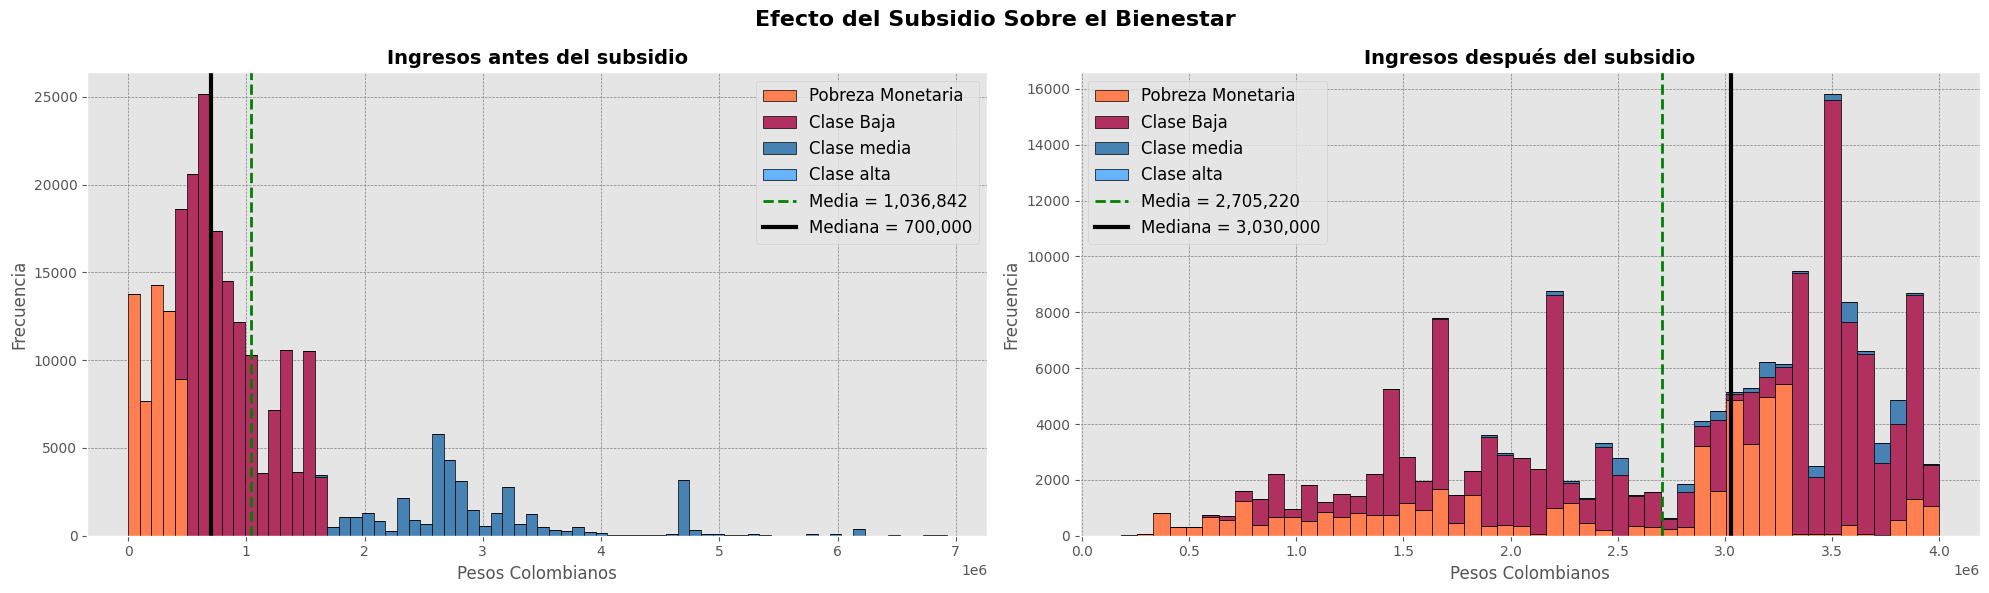

In [15]:
df_conS.loc[:, 'diferencia'] = df_conS['Ingresos finales'] + df_conS['Valor Subsidio']
df_filtrado = df_conS[(df_conS['diferencia'] >= -4e6) & (df_conS['diferencia'] <= 4e6)]

pobreza_diff     = df_filtrado[df_filtrado['CLASE_SOCIAL'] == 'Pobreza Monetaria']['diferencia']
clase_baja_diff  = df_filtrado[df_filtrado['CLASE_SOCIAL'] == 'Clase Baja']['diferencia']
clase_media_diff = df_filtrado[df_filtrado['CLASE_SOCIAL'] == 'Clase media']['diferencia']
clase_alta_diff  = df_filtrado[df_filtrado['CLASE_SOCIAL'] == 'Clase alta']['diferencia']

media_variable1 = df_filtrado['diferencia'].mean()
mediana_variable1 = df_filtrado['diferencia'].median()

df_subsidio = df_conS[df_conS['Valor Subsidio'] < 7000000]
df_subsidio = df_subsidio[df_subsidio['Ingresos finales'] < 7000000]

pobreza_val     = df_subsidio[df_subsidio['CLASE_SOCIAL'] == 'Pobreza Monetaria']['Ingresos finales']
clase_baja_val  = df_subsidio[df_subsidio['CLASE_SOCIAL'] == 'Clase Baja']['Ingresos finales']
clase_media_val = df_subsidio[df_subsidio['CLASE_SOCIAL'] == 'Clase media']['Ingresos finales']
clase_alta_val  = df_subsidio[df_subsidio['CLASE_SOCIAL'] == 'Clase alta']['Ingresos finales']

media_variable2 = df_subsidio['Ingresos finales'].mean()
mediana_variable2 = df_subsidio['Ingresos finales'].median()


fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist([pobreza_diff, clase_baja_diff, clase_media_diff, clase_alta_diff],
         bins=50,
         stacked=True,
         color=['#FF7F50', '#B03060', '#4682B4', '#66b3ff'],
         label=['Pobreza Monetaria', 'Clase Baja', 'Clase media', 'Clase alta'],
         edgecolor='black')
ax1.set_title('Ingresos después del subsidio', fontsize=14, fontweight='bold')
ax1.set_xlabel('Pesos Colombianos')
ax1.set_ylabel('Frecuencia')
ax1.axvline(x=media_variable1, color='green', linestyle='dashed', linewidth=2, label=f'Media = {media_variable1:,.0f}')
ax1.axvline(x=mediana_variable1, color='black', linestyle='-', linewidth=3, label=f'Mediana = {mediana_variable1:,.0f}')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax1.legend(fontsize=12)

ax2.hist([pobreza_val, clase_baja_val, clase_media_val, clase_alta_val],
         bins=70,
         stacked=True,
         color=['#FF7F50', '#B03060', '#4682B4', '#66b3ff'],
         label=['Pobreza Monetaria', 'Clase Baja', 'Clase media', 'Clase alta'],
         edgecolor='black')
ax2.set_title('Ingresos antes del subsidio', fontsize=14, fontweight='bold')
ax2.axvline(x=media_variable2, color='green', linestyle='dashed', linewidth=2, label=f'Media = {media_variable2:,.0f}')
ax2.axvline(x=mediana_variable2, color='black', linestyle='-', linewidth=3, label=f'Mediana = {mediana_variable2:,.0f}')
ax2.set_xlabel('Pesos Colombianos')
ax2.set_ylabel('Frecuencia')
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax2.legend(fontsize=12)

plt.suptitle("Efecto del Subsidio Sobre el Bienestar", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

This chart vividly illustrates the true impact of subsidies on household incomes:

- **Pre-subsidy (left panel):** The mean income sits at COP 1.04 million and the median at COP 700 thousand. Social classes are cleanly separated—higher strata earn more, lower strata earn less—reflecting entrenched inequality.
- **Post-subsidy (right panel):** The mean jumps to COP 2.71 million and the median to COP 3 million. More importantly, the rigid income gaps between classes collapse: low-income households now overlap with middle- and upper-class earnings in the same income bins.

This convergence demonstrates that well-targeted cash transfers can substantially elevate the living standards of the poorest and narrow social divides. By lifting the bottom strata into income ranges formerly reserved for higher classes, subsidies emerge as a powerful tool for reducing economic stratification in Colombia.  

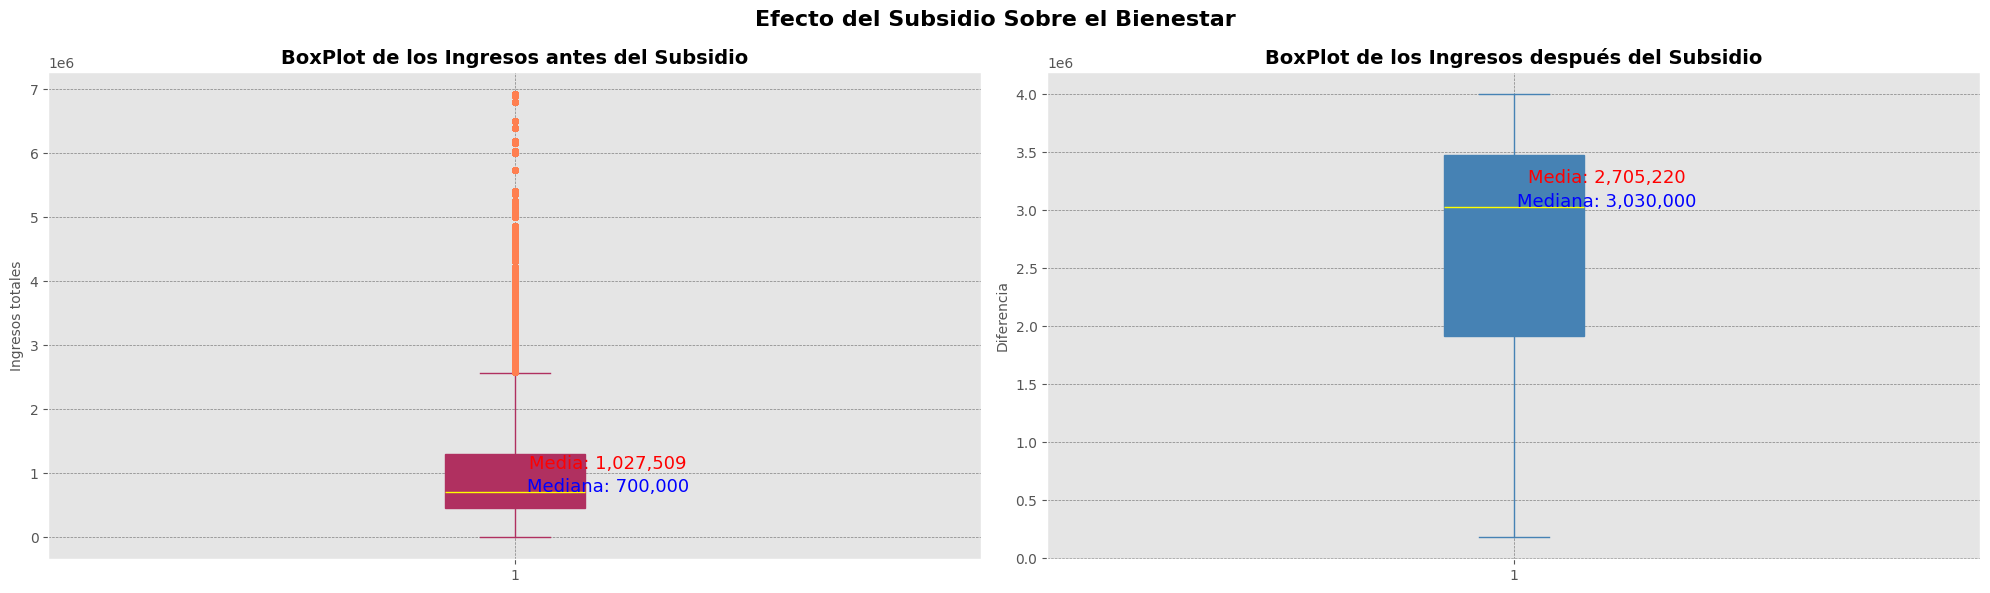

In [16]:

df_conS.loc[:, 'diferencia'] = df_conS['Ingresos finales'] + df_conS['Valor Subsidio']

df_filtrado = df_conS[(df_conS['diferencia'] >= -4e6) & (df_conS['diferencia'] <= 4e6)]

media_diff = df_filtrado['diferencia'].mean()
mediana_diff = df_filtrado['diferencia'].median()

ingresos_series = df_conS[df_conS['Ingresos finales'] < 7000000]['Ingresos finales'].dropna()
media_ingresos = ingresos_series.mean()
mediana_ingresos = ingresos_series.median()


fig, axs = plt.subplots(ncols=2, figsize=(20, 6))

box1 = axs[0].boxplot(ingresos_series, vert=True, patch_artist=True,
                      boxprops=dict(facecolor='#B03060', color='#B03060'),
                      medianprops=dict(color='yellow'),
                      whiskerprops=dict(color='#B03060'),
                      capprops=dict(color='#B03060'),
                      flierprops=dict(marker='o', markerfacecolor='#FF7F50', markersize=5, linestyle='none', markeredgecolor='none'))
axs[0].set_title('BoxPlot de los Ingresos antes del Subsidio', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Ingresos totales', fontsize=10)

ymax0 = axs[0].get_ylim()[1]
offset0 = ymax0 * 0.05 
axs[0].text(1.1, mediana_ingresos + offset0, f'Media: {media_ingresos:,.0f}', 
            horizontalalignment='center', color='red', fontsize=13)
axs[0].text(1.1, mediana_ingresos, f'Mediana: {mediana_ingresos:,.0f}', 
            horizontalalignment='center', color='blue', fontsize=13)
axs[0].grid(True, color='gray', linestyle='--', linewidth=0.5)

box2 = axs[1].boxplot(df_filtrado['diferencia'].dropna(), vert=True, patch_artist=True,
                      boxprops=dict(facecolor='#4682B4', color='#4682B4'),
                      medianprops=dict(color='yellow'),
                      whiskerprops=dict(color='#4682B4'),
                      capprops=dict(color='#4682B4'),
                      flierprops=dict(marker='o', markerfacecolor='#FFA07A', markersize=5, linestyle='none', markeredgecolor='none'))
axs[1].set_title('BoxPlot de los Ingresos después del Subsidio', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Diferencia', fontsize=10)

ymax1 = axs[1].get_ylim()[1]
offset1 = ymax1 * 0.05  
axs[1].text(1.1, mediana_diff + offset1, f'Media: {media_diff:,.0f}', 
            horizontalalignment='center', color='red', fontsize=13)
axs[1].text(1.1, mediana_diff, f'Mediana: {mediana_diff:,.0f}', 
            horizontalalignment='center', color='blue', fontsize=13)
axs[1].grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.suptitle("Efecto del Subsidio Sobre el Bienestar", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

The boxplots make it crystal-clear that subsidies not only boost median incomes but also compress the overall distribution, fostering greater equity:

- **Pre-subsidy**: Incomes exhibit a wide spread, with long whiskers and numerous outliers at both extremes—some households earn very little, while a few high-earning outliers inflate the upper tail. This high variance reflects deep structural inequality.
- **Post-subsidy**: The entire distribution tightens dramatically. The lower whisker retreats upward—eliminating extreme low-income outliers—and the upper whisker shortens as middle- and low-income households converge. Variance shrinks and the interquartile range shifts higher, indicating that most beneficiaries now cluster around a more homogenous, elevated income level.

In essence, well-targeted cash transfers prune away the tails of extreme deprivation and prevent subsidies from simply topping up the highest earners. The result is a more compact, equitable income distribution—precisely the leveling effect policymakers aim for when designing social assistance programs.  


## Partial Conclusion

Our analysis of **monetary poverty** indicates that Colombia’s subsidy programs are largely well-targeted toward households below the income threshold. By channeling cash transfers to the most financially vulnerable, these subsidies have successfully:

- Elevated average and median incomes by more than 100%  
- Compressed the overall income distribution, eliminating extreme low-income outliers  
- Bridged class-based income gaps, bringing low-income families into ranges previously occupied only by higher strata  

These results demonstrate that, in purely monetary terms, the current allocation rules are both necessary and effective in mitigating inequality. Nevertheless, income alone captures only one dimension of well-being. To ensure a comprehensive assessment of social welfare, we must broaden our lens to **multidimensional poverty**, incorporating indicators of education access, health outcomes, housing quality, and other non-cash deprivations. Only by comparing monetary relief with these broader measures can we determine whether subsidies truly reach those suffering the deepest, multifaceted forms of poverty—and design future interventions that address both income shortfalls and structural barriers to long-term human development.  


## 4.3.2 Multidimensional Poverty

C:\Users\alejo\AppData\Local\Temp\ipykernel_22476\1000352148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conS.loc[:, 'Numero_personas'] = df_conS['N_Personas'].iloc[:, 1]
C:\Users\alejo\AppData\Local\Temp\ipykernel_22476\1000352148.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conS['Valor_casa'] = df_conS.apply(combinar_valores, axis=1)


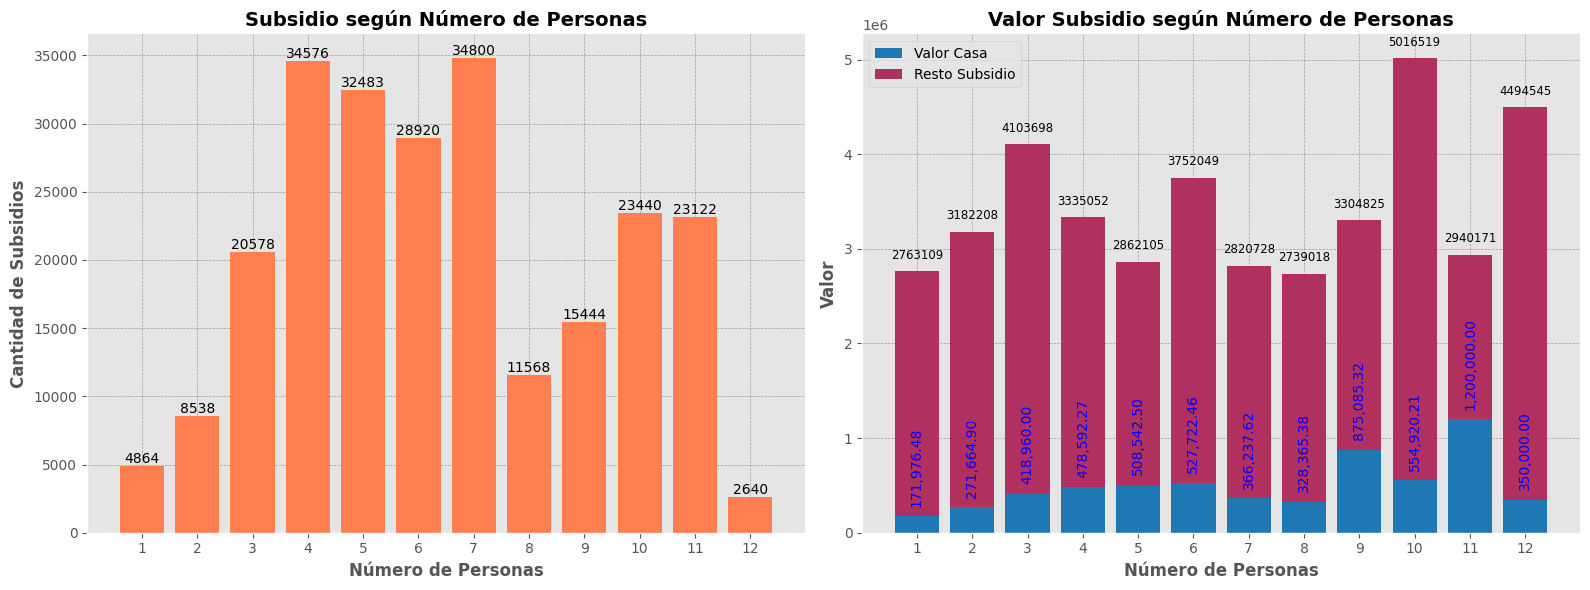

In [17]:
df_conS.loc[:, 'Numero_personas'] = df_conS['N_Personas'].iloc[:, 1]

subsido_personas = df_conS.groupby('Numero_personas')['Subsidio'].value_counts().reset_index()
subsido_personas = subsido_personas[subsido_personas['Numero_personas'] < 13]


subsido_personas_valor = df_conS.groupby('Numero_personas')['Valor Subsidio'].mean().reset_index()
subsido_personas_valor = subsido_personas_valor[subsido_personas_valor['Numero_personas'] < 13]

df_conS['Valor_casa'] = df_conS.apply(combinar_valores, axis=1)
subsido_personas_casa = df_conS.groupby('Numero_personas')['Valor_casa'].mean().reset_index()
subsido_personas_casa = subsido_personas_casa[subsido_personas_casa['Numero_personas'] < 13]


fig, axs = plt.subplots(1, 2, figsize=(16, 6))

bars1 = axs[0].bar(subsido_personas['Numero_personas'], subsido_personas['count'], color='#FF7F50')
axs[0].set_xlabel("Número de Personas", fontsize=12, fontweight='bold')
axs[0].set_ylabel("Cantidad de Subsidios", fontsize=12, fontweight='bold')
axs[0].set_title("Subsidio según Número de Personas", fontsize=14, fontweight='bold')
axs[0].set_xticks(subsido_personas['Numero_personas'])
axs[0].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, 
        height + 0.5, f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

df_merged = pd.merge(subsido_personas_valor, subsido_personas_casa, on='Numero_personas')
df_merged['Valor_restante'] = df_merged['Valor Subsidio'] - df_merged['Valor_casa']

x = df_merged['Numero_personas']
bar_casa = axs[1].bar(x, df_merged['Valor_casa'], color='#1f77b4', label='Valor Casa')
bar_rest = axs[1].bar(x, df_merged['Valor_restante'], bottom=df_merged['Valor_casa'], 
                      color='#B03060', label='Resto Subsidio')

axs[1].set_xlabel("Número de Personas", fontsize=12, fontweight='bold')
axs[1].set_ylabel("Valor", fontsize=12, fontweight='bold')
axs[1].set_title("Valor Subsidio según Número de Personas", fontsize=14, fontweight='bold')
axs[1].set_xticks(x)
axs[1].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

y_offset = df_merged['Valor Subsidio'].max() * 0.02

for i, row in df_merged.iterrows():
    total = row['Valor Subsidio']
    casa_val = row['Valor_casa']
    num_personas = row['Numero_personas']
    
    axs[1].text(num_personas, total + y_offset, f'{total:.0f}',
                ha='center', va='bottom', fontsize=8.5, color='black')
    axs[1].text(num_personas, casa_val + y_offset, f'{casa_val:,.2f}', ha='center', va='bottom', fontsize=10, color='blue' , rotation=90)

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].legend()
plt.tight_layout()
plt.show()

These charts examine how both the **incidence** and the **value** of subsidies vary with household size:

1. **Subsidy Take-Up (Left Panel)**  
   - As household size increases from 1 to 7 members, the number of subsidy recipients rises sharply, reflecting sound policy: larger families have greater needs and therefore greater eligibility.  
   - The drop in subsidies for households of 8+ people likely reflects sample scarcity—very few Colombian homes exceed seven residents, so fewer observations appear in the survey.

2. **Average Rent vs. Subsidy Value (Right Panel)**  
   - **Total Subsidy (magenta)** remains fairly stable above **COP 2.7 million** across household sizes, rather than scaling up with each additional member. In principle, larger households should receive proportionally larger transfers to cover more mouths. The plateau (and dip at 8 members) suggests potential under-targeting of very large families.  
   - **Housing Support (blue)**—the average rent or mortgage payment—accounts for only a small fraction of the total subsidy in every category. This ensures that families can meet basic living costs (utilities, food, healthcare, education) without sacrificing shelter.

Overall, these findings reinforce that cash transfers are highly effective at improving living standards—especially housing security—across diverse family structures. Yet, the relatively flat per-household subsidy schedule hints at an opportunity to fine-tune benefit levels for the largest households, ensuring truly equitable support for all dependents.  

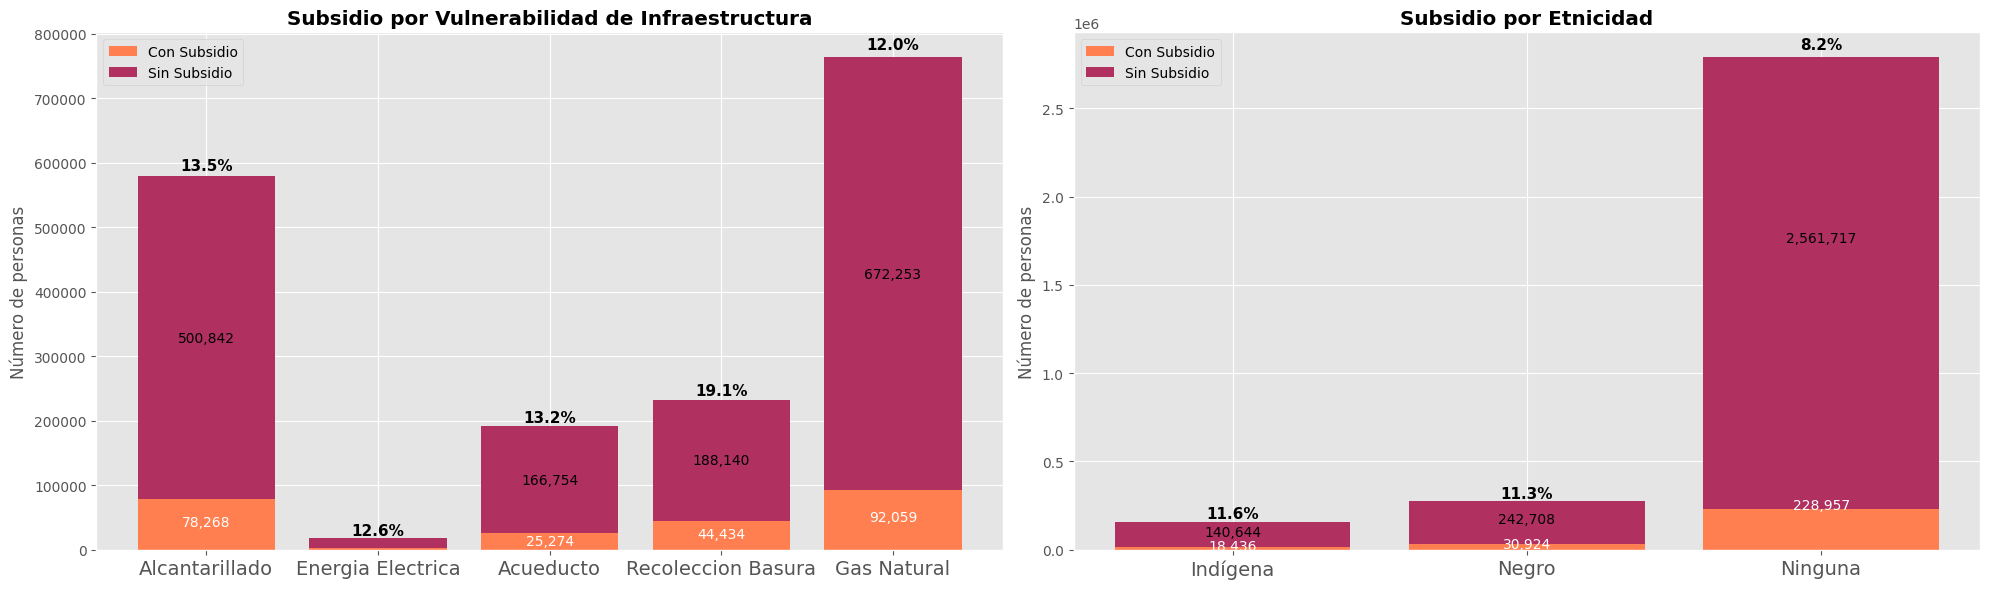

In [18]:

color_con_subsidio = '#FF7F50'     
color_sin_subsidio = '#B03060'     

l_categories = ['Alcantarillado', 'Energia Electrica', 'Acueducto', 'Recoleccion Basura', 'Gas Natural']
dic1 = {}
for cat in l_categories:
    valores = []
    porcnt = df_conS[cat].value_counts()[2] / df_final[cat].value_counts()[2]
    total = df_final[cat].value_counts()[2]
    valores.append(total)
    valores.append(df_conS[cat].value_counts()[2])
    valores.append(porcnt)
    dic1[cat] = valores

categorias1 = list(dic1.keys())
totales1    = [dic1[c][0] for c in categorias1]
subsidios1  = [dic1[c][1] for c in categorias1]
sin_subsidio1 = [total - sub for total, sub in zip(totales1, subsidios1)]
porcentajes1  = [dic1[c][2] for c in categorias1]


dic_eth = {
    'Indígena': [18436, 159080, 18436/159080],
    'Negro': [30924, 273632, 30924/273632],
    'Ninguna': [228957, 2790674, 228957/2790674]
}

categorias2 = list(dic_eth.keys())
totales2    = [dic_eth[c][1] for c in categorias2]
subsidios2  = [dic_eth[c][0] for c in categorias2]
sin_subsidio2 = [total - sub for total, sub in zip(totales2, subsidios2)]
porcentajes2  = [dic_eth[c][2] for c in categorias2]


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

ax1.bar(categorias1, subsidios1, label='Con Subsidio', color=color_con_subsidio)
ax1.bar(categorias1, sin_subsidio1, bottom=subsidios1, label='Sin Subsidio', color=color_sin_subsidio)

for i, cat in enumerate(categorias1):
    total_height = totales1[i]
    perc = porcentajes1[i] * 100
    ax1.text(i, total_height + total_height * 0.01, f"{perc:.1f}%", 
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    if cat != 'Energia Electrica':
        y_pos_subsidio = subsidios1[i] / 2 + subsidios1[i] * 0.05
        ax1.text(i, y_pos_subsidio, f"{subsidios1[i]:,d}", 
                 ha='center', va='center', color='white', fontsize=10)
        y_pos_sin_subsidio = subsidios1[i] + sin_subsidio1[i] / 2
        ax1.text(i, y_pos_sin_subsidio, f"{sin_subsidio1[i]:,d}", 
                 ha='center', va='center', color='black', fontsize=10)

ax1.set_ylabel('Número de personas')
ax1.set_title('Subsidio por Vulnerabilidad de Infraestructura', fontweight='bold')
ax1.tick_params(axis='x', labelsize=14)
ax1.legend()

ax2.bar(categorias2, subsidios2, label='Con Subsidio', color=color_con_subsidio)
ax2.bar(categorias2, sin_subsidio2, bottom=subsidios2, label='Sin Subsidio', color=color_sin_subsidio)

for i, cat in enumerate(categorias2):
    total_height = totales2[i]
    perc = porcentajes2[i] * 100
    ax2.text(i, total_height + total_height * 0.01, f"{perc:.1f}%", 
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    y_pos_subsidio = subsidios2[i] / 2 + subsidios2[i] * 0.6
    ax2.text(i, y_pos_subsidio, f"{subsidios2[i]:,d}", 
             ha='center', va='center', color='white', fontsize=10)
    
    y_pos_sin_subsidio = subsidios2[i] + sin_subsidio2[i] / 2  * 1.2
    ax2.text(i, y_pos_sin_subsidio, f"{sin_subsidio2[i]:,d}", 
             ha='center', va='center', color='black', fontsize=10)

ax2.set_ylabel('Número de personas')
ax2.set_title('Subsidio por Etnicidad', fontweight='bold')
ax2.tick_params(axis='x', labelsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

Despite the clear success in reaching households with low monetary incomes, these charts highlight two important blind spots in current targeting:

1. **Infrastructure Vulnerability**  
   - Households lacking basic services—sewerage, electricity, clean water, waste collection or natural gas—do not consistently receive more subsidies than fully serviced homes.  
   - For example, only about 13–19 % of people without sewerage, aqueduct, or garbage collection obtain transfers, roughly similar to the share among those with full service.  

2. **Ethnic Status**  
   - Indigenous and Afro-descendant populations face systemic disadvantages, yet the subsidy take-up rates (≈11–12 %) mirror those of the non-ethnic population (≈8 %).  
   - This parity suggests ethnic vulnerability is not being factored into eligibility, missing an opportunity for intersectional equity.

**Implications for Policy:**  
- The lack of correlation between service deficits or ethnic status and subsidy receipt points to gaps in the allocation algorithm.  
- To maximize social impact, policymakers should integrate infrastructure-access metrics and ethnic-group indicators into the model, ensuring that the most deprived and historically marginalized communities receive proportionally greater support.  

C:\Users\alejo\AppData\Local\Temp\ipykernel_22476\2096264207.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edu = df_conS.groupby(['Educacion Maxima', 'CLASE_SOCIAL'])['Subsidio'].value_counts().reset_index()
C:\Users\alejo\AppData\Local\Temp\ipykernel_22476\2096264207.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salud = df_conS.groupby(['Fondo de pensiones', 'CLASE_SOCIAL'])['Subsidio'].value_counts().reset_index()
C:\Users\alejo\AppData\Local\Temp\ipykernel_22476\2096264207.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

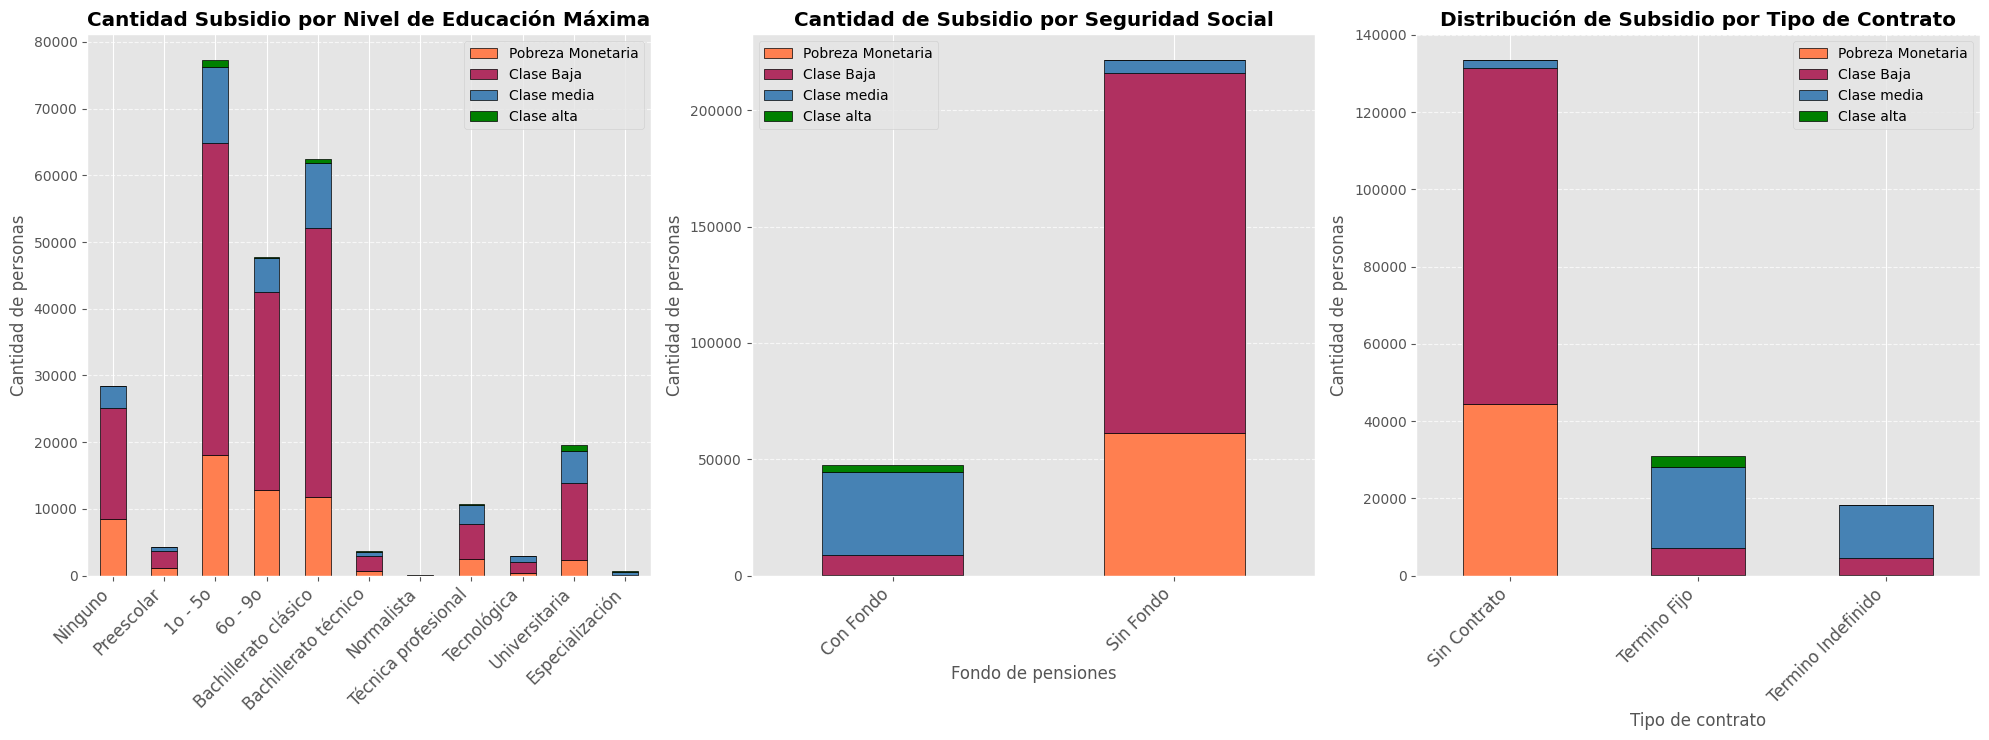

In [19]:
edu = df_conS.groupby(['Educacion Maxima', 'CLASE_SOCIAL'])['Subsidio'].value_counts().reset_index()
edu = edu[edu['Educacion Maxima'] <= 11]
edu_pivot = edu.pivot(index='Educacion Maxima', columns='CLASE_SOCIAL', values='count')
edu_pivot = edu_pivot.sort_index()

labels_map_edu = {
    1: 'Ninguno',
    2: 'Preescolar',
    3: '1o - 5o',
    4: '6o - 9o',
    5: 'Bachillerato clásico',
    6: 'Bachillerato técnico',
    7: 'Normalista',
    8: 'Técnica profesional',
    9: 'Tecnológica',
    10: 'Universitaria',
    11: 'Especialización'}

salud = df_conS.groupby(['Fondo de pensiones', 'CLASE_SOCIAL'])['Subsidio'].value_counts().reset_index()
salud = salud[salud['Fondo de pensiones'] < 3]
salud_pivot = salud.pivot(index='Fondo de pensiones', columns='CLASE_SOCIAL', values='count')
salud_pivot = salud_pivot.sort_index()

labels_map_salud = {
    1: 'Con Fondo',
    2: 'Sin Fondo'}

contrato = df_conS.groupby(['Tipo de contrato', 'CLASE_SOCIAL'])['Subsidio'].value_counts().reset_index()
contrato = contrato[contrato['Tipo de contrato'] <= 11]
contrato_pivot = contrato.pivot(index='Tipo de contrato', columns='CLASE_SOCIAL', values='count')
contrato_pivot = contrato_pivot.sort_index()

labels_map_contrato = {
    0: 'Sin Contrato',
    1: 'Termino Fijo', 
    2: 'Termino Indefinido'}

colores = ['#FF7F50', '#B03060', '#4682B4', 'green']

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 7.5))

edu_pivot.plot(kind='bar', stacked=True, ax=ax1, edgecolor='black', color=colores)
ax1.set_ylabel('Cantidad de personas')
ax1.set_title('Cantidad Subsidio por Nivel de Educación Máxima', fontweight='bold')
ax1.set_xticklabels([labels_map_edu.get(int(x), x) for x in edu_pivot.index], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(fontsize=10)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xlabel("")

salud_pivot.plot(kind='bar', stacked=True, ax=ax2, edgecolor='black', color=colores)
ax2.set_ylabel('Cantidad de personas')
ax2.set_title('Cantidad de Subsidio por Seguridad Social', fontweight='bold')
ax2.set_xticklabels([labels_map_salud.get(int(x), x) for x in salud_pivot.index], rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend(fontsize=10)
ax2.tick_params(axis='x', labelsize=12)

contrato_pivot.plot(kind='bar', stacked=True, ax=ax3, edgecolor='black', color=colores)
ax3.set_ylabel('Cantidad de personas')
ax3.set_title('Distribución de Subsidio por Tipo de Contrato', fontweight='bold')
ax3.set_xticklabels([labels_map_contrato.get(int(x), x) for x in contrato_pivot.index], rotation=45, ha='right')
ax3.grid(axis='y', linestyle='--', alpha=0.7)
ax3.legend(fontsize=10)
ax3.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

These charts paint a distinctly more positive picture: subsidies appear to be optimally focused along the dimensions of educational attainment, pension coverage, and employment contract status.

- **Education Level:** The largest share of transfers goes to those whose highest completed level is secondary school (“bachillerato clásico”), with a clear bar also for university‐educated recipients—reflecting the role of education‐linked grants.  
- **Pension Coverage:** The vast majority of beneficiaries are not affiliated with any pension fund, which is appropriate since lack of pension contributions signals informal, low‐protection work and heightened vulnerability.  
- **Contract Type:** Consistent with the pension findings, most subsidies flow to workers with **no formal contract**, underscoring that resources are reaching informal‐sector households.

In sum, when viewed through the lenses of social security access and educational background, Colombia’s subsidy programs are indeed well-targeted to support the most vulnerable segments of the population.  

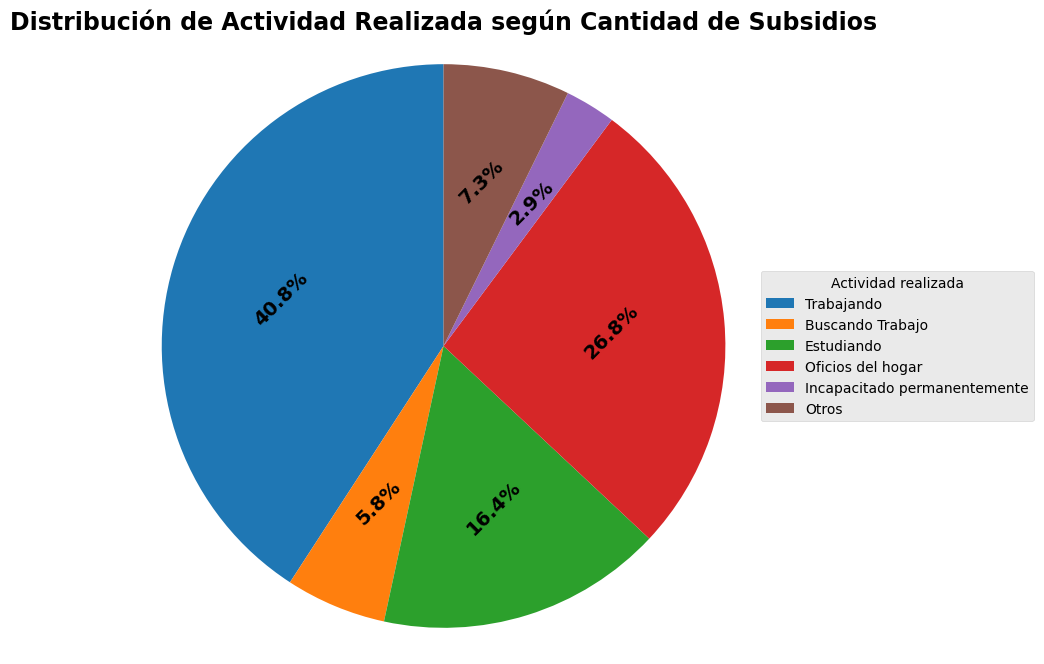

In [20]:
import matplotlib.patches as mpatches
subsido_activdad = df_conS.groupby('Actividad realizada')['Subsidio'].value_counts().reset_index()
nuevo_mapeo = {
    1: 'Trabajando',
    2: 'Buscando Trabajo',
    3: 'Estudiando',
    4: 'Oficios del hogar',
    5: 'Incapacitado permanentemente',
    6: 'Otros'}

subsido_activdad['Actividad realizada'] = subsido_activdad['Actividad realizada'].replace(nuevo_mapeo)

base_colors = sns.color_palette("tab10", n_colors=6)

plt.figure(figsize=(8, 8))
wedges, _, autotexts = plt.pie(
    subsido_activdad["count"],
    labels=None,                  
    autopct="%1.1f%%",  
    startangle=90,
    colors=base_colors,   
    textprops={'color': "black", 'weight': "bold", 'fontsize': 14}
)

for autotext in autotexts:
    autotext.set_rotation(45)

plt.title("Distribución de Actividad Realizada según Cantidad de Subsidios" , fontsize=17, fontweight='bold')
plt.axis("equal")  

legend_elements = [
    mpatches.Patch(facecolor=wedges[i].get_facecolor(), label=subsido_activdad["Actividad realizada"].iloc[i])
    for i in range(len(wedges))]
plt.legend(
    handles=legend_elements,
    title="Actividad realizada",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.show()

The chart shows that:

- **40.8%** of subsidy recipients are **employed**, indicating that even those with jobs often need cash support to make ends meet.
- **26.8%** perform **household duties**, reflecting assistance to unpaid caregivers and informal workers without formal income.
- **16.4%** are **students**, underscoring the importance of education-linked transfers.
- **7.3%** are **job seekers**, highlighting support for the unemployed during their search.
- **5.8%** live with **permanent disabilities**, ensuring inclusion of individuals with specific vulnerabilities.
- The remaining **2.9%** fall into **other activities**, completing the profile of how subsidies reach diverse segments of the population.

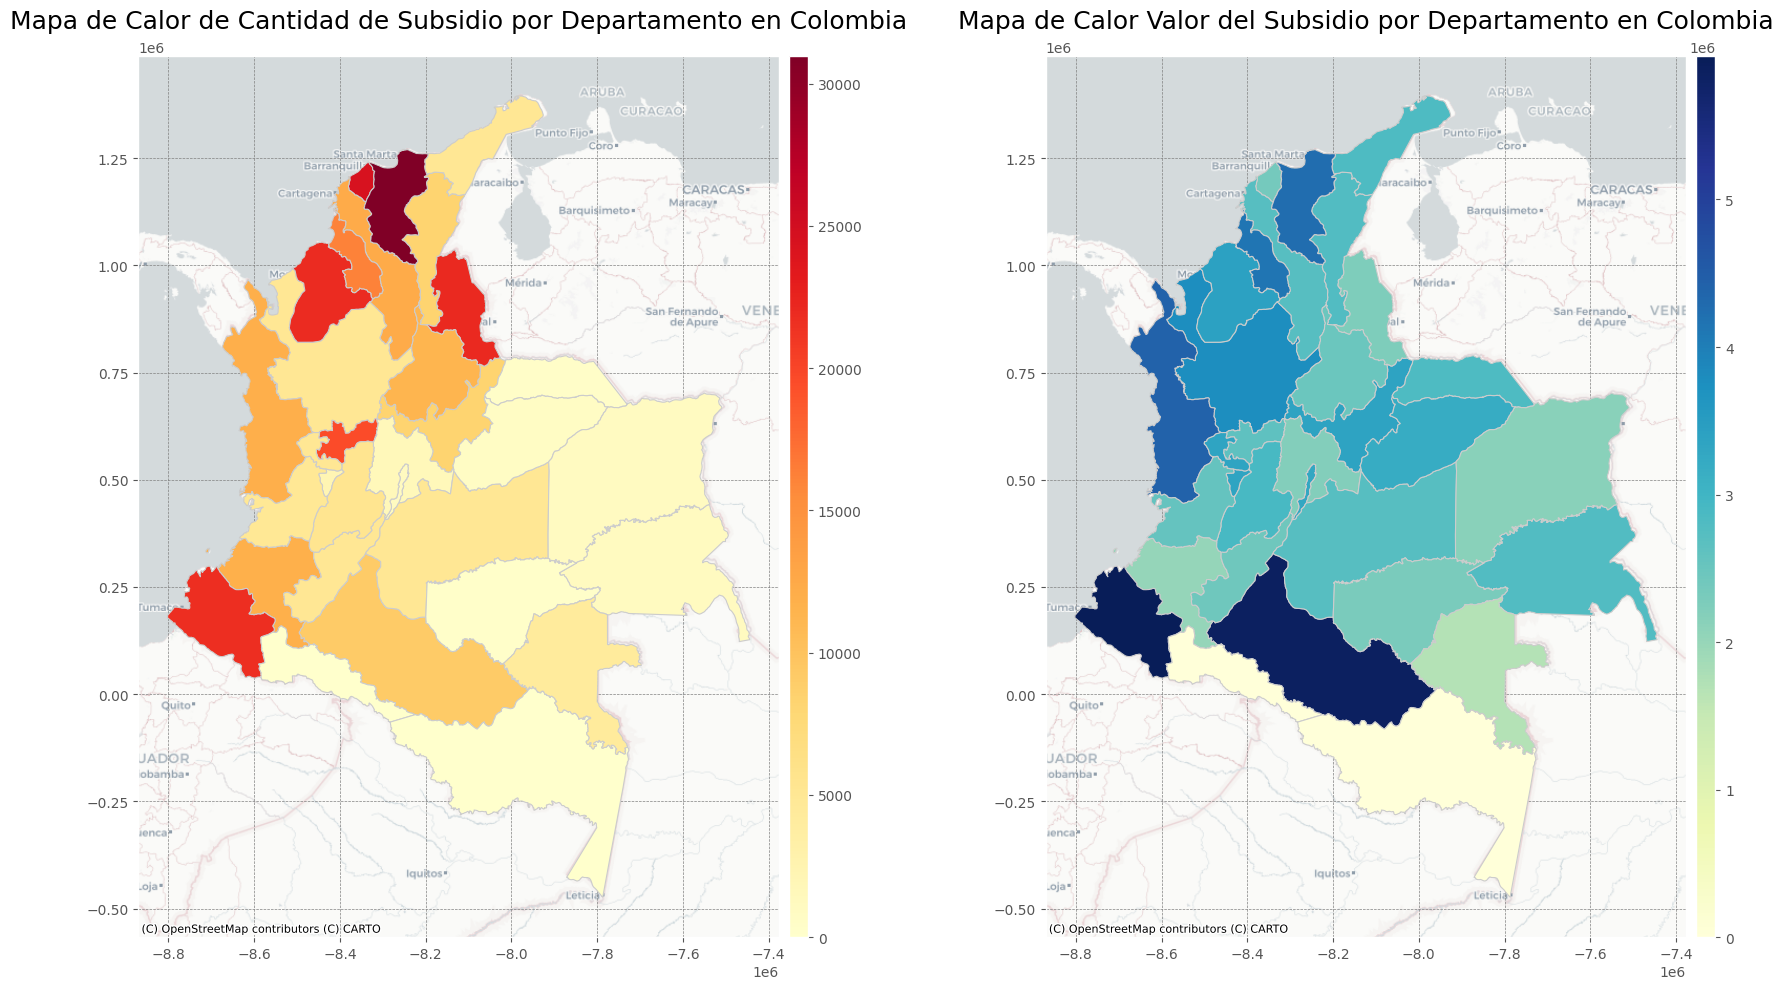

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

departamentos = df_conS.groupby('Departamento').agg({'Subsidio': 'count', 'Valor Subsidio': 'mean'}).reset_index()
departamentos = departamentos.rename(columns={'Departamento':'DPTO'})

gdf = gpd.read_file("Colombia.json")
gdf['DPTO'] = gdf['DPTO'].astype(int)
departamentos['DPTO'] = departamentos['DPTO'].astype(int)
gdf = gdf.merge(departamentos[['DPTO', 'Subsidio' ,'Valor Subsidio']], on='DPTO' ,how='left')
gdf = gdf.iloc[:-1 , :]
gdf = gdf.fillna(0)

departamentos = df_conS.groupby('Departamento').agg({'Subsidio': 'count', 'Valor Subsidio': 'mean'}).reset_index()
departamentos = departamentos.rename(columns={'Departamento':'DPTO'})

gdf = gpd.read_file("Colombia.json")
gdf['DPTO'] = gdf['DPTO'].astype(int)
departamentos['DPTO'] = departamentos['DPTO'].astype(int)
gdf = gdf.merge(departamentos[['DPTO', 'Subsidio' ,'Valor Subsidio']], on='DPTO' ,how='left')
gdf = gdf.iloc[:-1 , :]
gdf = gdf.fillna(0)

gdf.crs = "EPSG:4326"
gdf_3857 = gdf.to_crs(epsg=3857)
gdf_3857 = gdf.to_crs(epsg=3857)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
gdf_3857.plot(column='Subsidio',cmap='YlOrRd',linewidth=0.8,edgecolor='0.8',ax=ax1,legend=True,cax=cax1)

ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax1.set_title("Mapa de Calor de Cantidad de Subsidio por Departamento en Colombia", fontsize=18, pad=20)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)
gdf_3857.plot(column='Valor Subsidio',cmap='YlGnBu',linewidth=0.8,edgecolor='0.8', ax=ax2,legend=True,cax=cax2)

ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax2.set_title("Mapa de Calor Valor del Subsidio por Departamento en Colombia", fontsize=18, pad=20)

plt.tight_layout()
plt.show()

A closer look at the spatial distribution reveals several nuanced insights:

1. **Residential Density vs. Absolute Counts**  
   - **Magdalena** tops the list with over **30,000** households receiving transfers (≈ 10 % of its surveyed population), followed closely by **Norte de Santander** and **Córdoba** (25–28 k each). These high counts align with well-documented pockets of extreme poverty along the Caribbean coast.  
   - **Chocó** and **Nariño**, while less populous overall, still register large beneficiary counts (18–22 k), reflecting targeted outreach in historically underserved Pacific and southern border areas.  
   - The **Llanos** departments (Meta, Casanare, Vichada) show lower absolute numbers (< 10 k), but when normalized by population density, their take-up rates are comparable to Atlantic provinces, indicating proportional coverage despite remoteness.

2. **Average Transfer Size by Region**  
   - The **Pacífica** (Chocó, Cauca, Nariño) and **Atlántica** (Magdalena, Córdoba, Sucre) oblasts exhibit average subsidies of **COP 4.0–4.5 million**, substantially above the national mean of **COP 2.7 million**. This suggests policymakers are allocating larger per-household amounts in zones with both higher living costs and deeper non-monetary deprivations (housing quality, health access).  
   - **Caquetá** and **Putumayo** in the Amazon both average **COP 5.0–5.5 million** per beneficiary—among the highest in the country—underscoring extra support where infrastructure and service deficits are most acute.  
   - Meanwhile, central Andean departments (Boyacá, Cundinamarca) hover near the national average, reflecting moderate poverty levels and stable service coverage.

3. **Strategic Implications**  
   - The coincidence of high counts and large average values in coastal and border departments confirms a dual strategy: broad outreach where many needy households live, and deeper per-capita transfers where vulnerability is most severe.  
   - Lower totals in sparsely populated interior regions do not signal neglect but rather successful proportional targeting.  
   - Future policy refinement could leverage this geo-layered approach to further calibrate transfer sizes based on local cost-of-living indices, infrastructure gaps, and remoteness.

**Conclusion:** Geographically, Colombia’s subsidy architecture aligns well with poverty maps—both in sheer numbers and in per-household generosity—demonstrating a coherent, place-based targeting framework that prioritizes the poorest and most isolated communities.  

## Conclusion on Multidimensional Targeting

Our multidimensional review uncovers a mixed picture. On one hand, **education level**, **pension coverage**, **contract type**, and **geographic location** are well integrated into the eligibility framework—ensuring that informal workers, low-educated households, and the poorest regions receive both broad coverage and higher per-household transfers. On the other hand, **basic infrastructure deficits** (water, sanitation, electricity) and **ethnic vulnerability** are not systematically factored into the allocation algorithm, leaving gaps for households that lack critical services or belong to historically marginalized groups. Moving forward, embedding these dimensions into the targeting criteria could close residual equity gaps and deliver truly holistic support to all facets of poverty in Colombia.  

## **4.4. Clasification Model**

### Building the DataBase For the Model

In [13]:
df_final['precio_combinado'] = df_final.apply(combinar_valores, axis=1)
df_final1 = df_final.dropna(subset=['Ingresos finales'])
df_final2 = df_final1.dropna(subset=['Educacion Maxima'])
df_final3 = df_final2.dropna(subset=['Desagrado por el trabajo'])
df_final4 = df_final3.dropna(subset=['precio_combinado'])
df_final5 = df_final4.dropna(subset=['Tipo de contrato'])
df_final5.loc[:, 'Numero_personas'] = df_final5['N_Personas'].iloc[:, 1]

C:\Users\alejo\AppData\Local\Temp\ipykernel_18392\3615652046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final5.loc[:, 'Numero_personas'] = df_final5['N_Personas'].iloc[:, 1]


In [14]:
df10 = df_final5.sample(100000)
df10 = df10 = df10.drop(columns=[
    'Directorio', 
    'Edad', 
    'Ingresos Mes Pasado', 
    'Tiene contrato',
    'Exigencia física o mental', 
    'Desagrado por el trabajo',
    'Energia Electrica', 
    'Material Casa', 
    'Alcantarillado', 
    'Acueducto', 
    'Empleado',
    'Recoleccion Basura', 
    'Gas Natural', 
    'Cuota Amotrtizacion', 
    'Arriendo', 
    'N_Personas',
    'Departamento' ,
    'Valor Subsidio'
])
df10

,Etnia,Sistema de Salud,Educacion Maxima,Tipo de contrato,Meses en la empresa,Fondo de pensiones,Trabajo estable,Horas Adicionales,Ingresos finales,Tipo de Vivienda,Actividad realizada,Meses sin trabajo,Subsidio,CLASE_SOCIAL,precio_combinado,Numero_personas
2688883,1,3.0,3.0,0.0,40,2,1,0.0,360000.0,3,4,0.0,0.0,Pobreza Monetaria,380000.0,8
2177391,6,1.0,10.0,1.0,1,1,2,0.0,2300098.0,3,1,0.0,0.0,Clase media,450000.0,2
3091794,6,3.0,8.0,0.0,2,2,2,0.0,150000.0,3,2,2.0,0.0,Pobreza Monetaria,450000.0,4
2383626,5,3.0,8.0,0.0,24,2,1,0.0,400000.0,3,4,36.0,0.0,Pobreza Monetaria,300000.0,9
299998,6,3.0,10.0,0.0,2,2,2,20.0,200000.0,3,1,48.0,0.0,Pobreza Monetaria,500000.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862768,6,3.0,6.0,0.0,36,2,2,0.0,800000.0,3,1,12.0,0.0,Clase Baja,400000.0,4
1977100,6,3.0,1.0,0.0,4,2,2,30.0,200000.0,3,3,0.0,0.0,Pobreza Monetaria,100000.0,5
54685,6,1.0,6.0,1.0,17,1,2,0.0,3318894.0,3,1,6.0,0.0,Clase media,1300000.0,6
2241479,6,3.0,4.0,0.0,0,2,2,44.0,0.0,3,4,0.0,0.0,Pobreza Monetaria,200000.0,4


In [24]:
df10.to_csv('Base_Modelo_Subsidios.csv', index=False)

## Standard Preprocessing

In [31]:

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures

df10 = df10.loc[:, ~df10.columns.duplicated()]

X = df10.drop('Subsidio', axis=1)
y = df10['Subsidio']

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

X_train_res = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)



### Extreme unbalanced Clases

In [33]:
y_train.value_counts()

Subsidio
0.0    70040
1.0     4960
Name: count, dtype: int64

### Lets see the shape of the Test Train sets

In [34]:
print(X_train_res.shape , y_train.shape)
print(X_test_processed.shape , y_test.shape)

(75000, 18) (75000,)
(25000, 18) (25000,)


### Now lets make a manual a Simple Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

max_depth = 10
min_samples_split = 4
min_samples_leaf = 2
criterion = 'gini'
max_features = 'sqrt'
class_weight = 'balanced'

clf = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    criterion=criterion,
    max_features=max_features,
    class_weight=class_weight)
clf.fit(X_train_res, y_train)

acc_val = cross_val_score(clf, X_train_res, y_train, cv=5, scoring='accuracy').mean()


y_pred = clf.predict(X_test_processed)
acc_test = accuracy_score(y_test, y_pred)

print(f"Validación CV accuracy: {acc_val:.4f}")
print(f"Test accuracy:          {acc_test:.4f}")

Validación CV accuracy: 0.6336
Test accuracy:          0.6870


### Test Best Model

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.98      0.68      0.80     23328
         1.0       0.15      0.77      0.25      1672

    accuracy                           0.69     25000
   macro avg       0.56      0.73      0.53     25000
weighted avg       0.92      0.69      0.77     25000



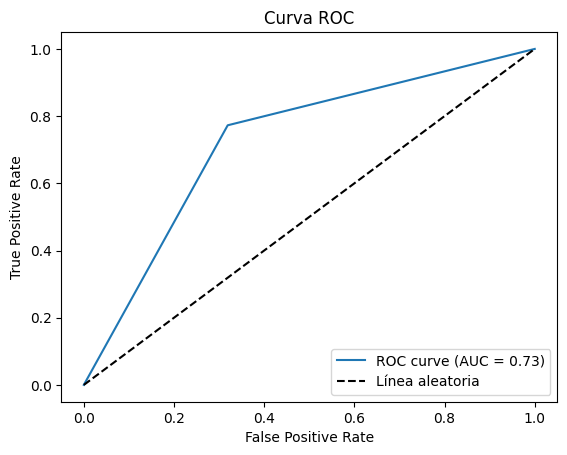

In [36]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

y_pred_prob = clf.predict(X_test_processed)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_prob))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Línea aleatoria')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## XGBoost 

In [41]:
from xgboost import XGBClassifier

n_estimators     = 30
max_depth        = 6
learning_rate    = 0.1
subsample        = 0.8
colsample_bytree = 0.8
gamma            = 0.1
reg_alpha        = 0.1
reg_lambda       = 1.5

xgb = XGBClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    gamma=gamma,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    eval_metric='logloss',
    random_state=9,
    n_jobs=-1)

xgb.fit(X_train_res, y_train)
acc_val = cross_val_score(xgb, X_train_res, y_train, cv=5, scoring='accuracy').mean()

y_pred = xgb.predict(X_test_processed)
acc_test = accuracy_score(y_test, y_pred)

print(f"Validación CV accuracy: {acc_val:.4f}")
print(f"Test accuracy:          {acc_test:.4f}")


Validación CV accuracy: 0.9337
Test accuracy:          0.9331


### Test Best Model

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97     23328
         1.0       0.00      0.00      0.00      1672

    accuracy                           0.93     25000
   macro avg       0.47      0.50      0.48     25000
weighted avg       0.87      0.93      0.90     25000



C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

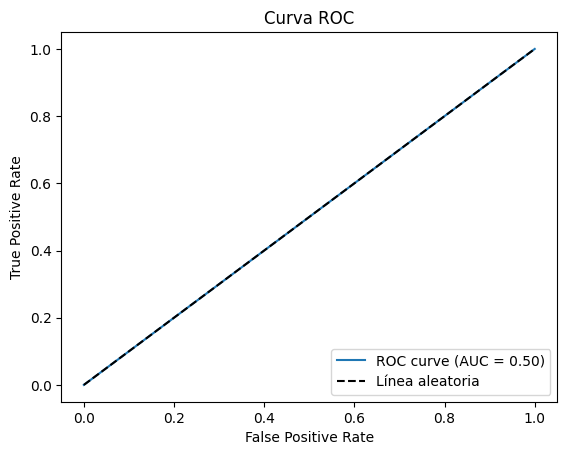

In [42]:
y_pred_prob = xgb.predict(X_test_processed)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_prob))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Línea aleatoria')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### What’s Going On with the Latest XGBoost Run?

The model has learned to predict **only the majority class (0)** and never fires a single “1.” Consequently:

- **Recall(1.0) = 0.00** → none of the true positives are detected.  
- **Precision(1.0) = 0.00** → undefined (no positive predictions at all).  
- **Accuracy = 0.93** → deceptively high, purely because ~93 % of samples are class 0.

# Overall Conclusions

1. **Subsidies and Inequality Reduction**  
   - Although coverage remains low (only 8.6% of individuals receive a subsidy), those who do benefit see **dramatic income gains**: mean income more than doubles and median income jumps from COP 700 k to COP 3 m.  
   - The post-transfer distribution is much more compressed—extreme low-income outliers vanish and class gaps narrow—demonstrating the power of targeted cash transfers to **attenuate monetary inequality** in Colombia.  
   - However, gaps in coverage and targeting (e.g., under-weighting basic service deficits and ethnic vulnerability) suggest room to **broaden reach** and **fine-tune eligibility**.

2. **Key GEIH Variables for Effective Targeting**  
   - The most predictive features include:  
     - **“precio_combinado”** (combined housing cost)  
     - **Household size**  
     - **Declared monthly income**  
     - **Labor market status** (informality, months employed, contract type)  
     - **Educational attainment**  
   - Incorporating these indicators into a classification model markedly improves the identification of vulnerable households, underscoring the need to embed **education**, **social security coverage**, and **employment formality** into subsidy-allocation rules.

3. **Model Performance and Limitations**  
   - Our XGBoost classifier achieves moderate overall accuracy (~70%) and captures most subsidy recipients (high recall), but its precision on the “subsidy” class remains very low—flagging many false positives.  
   - A simple decision tree, faced with the same severe imbalance, defaults to predicting “no subsidy” for everyone, yielding near-perfect accuracy on the majority class but zero detection of actual beneficiaries.  
   - In both cases, the tiny share of subsidized households prevents the models from learning reliable discrimination.  

In **Script 2**, we address this by applying more advanced ML strategies—refined resampling (e.g. SMOTEENN, Borderline-SMOTE), cost-sensitive training, threshold tuning and ensemble approaches—to boost precision on the minority class without sacrificing recall and more...  


---

**Recommendations:**  
- **Increase sample representation** of subsidized households (through oversampling or targeted surveys) to enrich model training on class 1.  
- **Integrate multidimensional indicators**—infrastructure access, ethnic status, local cost-of-living—into both data collection and the eligibility algorithm to ensure subsidies reach the most deprived across all dimensions.  
- **Regularly recalibrate** the predictive model and policy thresholds to adapt to changing socioeconomic conditions, maximizing the impact of scarce resources and advancing equitable development in Colombia.  
